In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_7.MOV
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_25.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_24.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_17.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_16.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_4.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_42.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_14.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_5.MOV
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_18.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_9.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_27.mp4
/kaggle/input/its-hammer-curl/hammer_curl/correct/hammer_curl_correct_11.mp4
/ka

In [2]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [11]:
import mediapipe as mp
import cv2
import numpy as np

mp_pose = mp.solutions.pose

def extract_pose_landmarks(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

    landmarks_list = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
            landmarks_list.append(keypoints)

        frame_count += 1

    cap.release()
    pose.close()

    # Pad to max_frames
    while len(landmarks_list) < max_frames:
        landmarks_list.append([0] * 132)  # 33 landmarks × 4 features

    return np.array(landmarks_list)


In [13]:
import os
import glob

def process_videos(folder, label, max_frames=100):
    data = []
    for video_path in glob.glob(os.path.join(folder, "*.mp4")):
        sequence = extract_pose_landmarks(video_path, max_frames=max_frames)
        data.append((sequence, label))
    return data

correct_data = process_videos('/kaggle/input/its-hammer-curl/hammer_curl/correct', label=1)
wrong_data = process_videos('/kaggle/input/its-hammer-curl/hammer_curl/wrong', label=0)

full_data = correct_data + wrong_data
X, y = zip(*full_data)
X = np.array(X)
y = np.array(y)


W0000 00:00:1749219542.752507    1071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749219542.811090    1071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749219545.591729    1078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749219545.658793    1078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749219548.586991    1088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749219548.642474    1088 inference_feedback_manager.cc:114] Feedback manager 

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AdditiveAttention(Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):  # values = LSTM outputs, query = context (usually last LSTM output)
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

sequence_input = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps, features)

# Bi-LSTM or LSTM
lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(sequence_input)

# Use hidden state as query
attention_layer = AdditiveAttention(units=32)
context_vector, attention_weights = attention_layer(lstm_out, state_h)

# Final prediction
x = Dropout(0.3)(context_vector)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 132)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 64),      │         50,432 │ input_layer_1[0][0]    │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additive_attention        │ [(None, 64), (None,    │          4,193 │ lstm[0][0], lstm[0][1] │
│ (AdditiveAttention)       │ 100, 1)]               │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ additive_attention[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 54,690 (213.63 KB)

 Trainable params: 54,690 (213.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=4
)


Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4367 - loss: 0.7498 - val_accuracy: 0.6154 - val_loss: 0.6749
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6933 - loss: 0.5700 - val_accuracy: 0.6923 - val_loss: 0.6765
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7343 - loss: 0.5458 - val_accuracy: 0.5385 - val_loss: 0.6998
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7814 - loss: 0.5246 - val_accuracy: 0.5385 - val_loss: 0.7190
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8693 - loss: 0.4183 - val_accuracy: 0.5385 - val_loss: 0.6950
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7880 - loss: 0.4929 - val_accuracy: 0.6154 - val_loss: 0.6343
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7767 - loss: 0.4950 - val_accuracy: 0.6154 - val_loss: 0.6369
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7516 - loss: 0.4149 - val_accuracy: 0.6154 - v

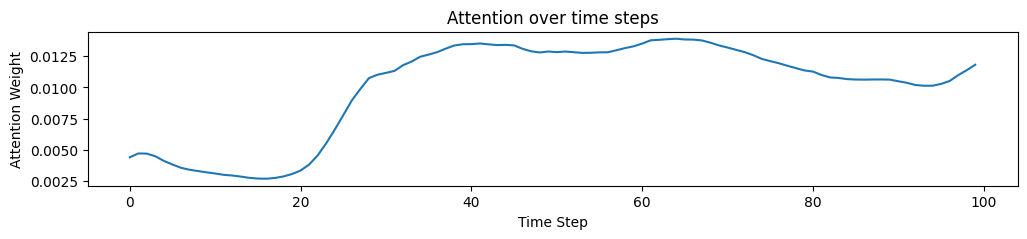

In [17]:
import matplotlib.pyplot as plt

def visualize_attention(sequence, attention_weights):
    plt.figure(figsize=(12, 2))
    plt.title("Attention over time steps")
    plt.plot(attention_weights.numpy().squeeze())
    plt.xlabel("Time Step")
    plt.ylabel("Attention Weight")
    plt.show()

# Get attention on a sample
sample = X_val[0:1]  # shape (1, time, features)
lstm_out, state_h, state_c = model.layers[1](sample)
_, att_weights = model.layers[2](lstm_out, state_h)

visualize_attention(sample, att_weights)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.50      0.40      0.44         5

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



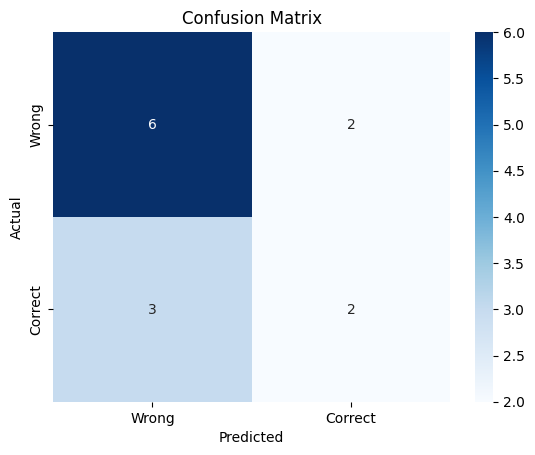

ROC-AUC Score: 0.6500


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Wrong', 'Correct'], yticklabels=['Wrong', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_score = roc_auc_score(y_val, y_pred_probs)
print(f"ROC-AUC Score: {roc_score:.4f}")


In [19]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [30]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

# Your custom AdditiveAttention
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def objective(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    attention_units = trial.suggest_int("attention_units", 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # Model definition
    sequence_input = Input(shape=(X.shape[1], X.shape[2]))
    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(sequence_input)
    context_vector, _ = AdditiveAttention(attention_units)(lstm_out, state_h)
    x = Dropout(dropout_rate)(context_vector)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=sequence_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=batch_size,
        verbose=0  # Suppress output for speed
    )

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Run the search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print the best result
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-06 14:41:21,281] A new study created in memory with name: no-name-b12ede24-a67c-4261-8199-2a986768fc3f
[I 2025-06-06 14:41:25,737] Trial 0 finished with value: 0.5384615659713745 and parameters: {'lstm_units': 59, 'attention_units': 41, 'dropout_rate': 0.10214164427070377, 'learning_rate': 0.008172385481194356, 'batch_size': 16}. Best is trial 0 with value: 0.5384615659713745.
[I 2025-06-06 14:41:30,145] Trial 1 finished with value: 0.4615384638309479 and parameters: {'lstm_units': 37, 'attention_units': 64, 'dropout_rate': 0.47818325325720823, 'learning_rate': 0.0017213798135756056, 'batch_size': 32}. Best is trial 0 with value: 0.5384615659713745.
[I 2025-06-06 14:41:34,445] Trial 2 finished with value: 0.5384615659713745 and parameters: {'lstm_units': 62, 'attention_units': 34, 'dropout_rate': 0.20681885994325003, 'learning_rate': 0.0025126790634310693, 'batch_size': 16}. Best is trial 0 with value: 0.5384615659713745.
[I 2025-06-06 14:41:40,388] Trial 3 finished with val

Best trial:
  Value: 0.8461538553237915
  Params: 
    lstm_units: 86
    attention_units: 17
    dropout_rate: 0.390418585536256
    learning_rate: 0.00023704568379232486
    batch_size: 4


In [22]:
# Use the best parameters to retrain the model
best_params = study.best_trial.params


In [23]:
pip install optuna[visualization]


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_35/807101538.py:11: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



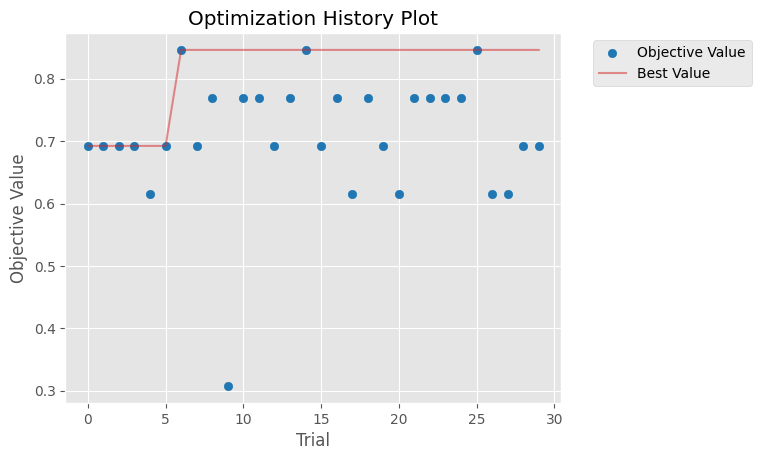

/tmp/ipykernel_35/807101538.py:14: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



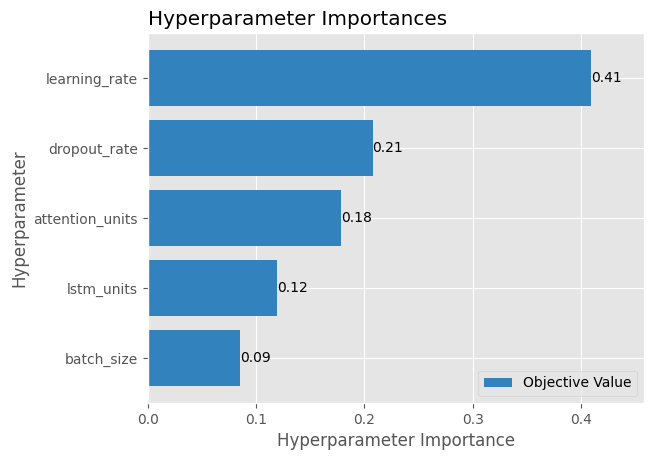

In [24]:
import optuna.visualization as vis
import optuna.visualization.matplotlib as vis_mat
import matplotlib.pyplot as plt

# Interactive plots (requires Jupyter or web-based environment)
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_parallel_coordinate(study).show()

# Static Matplotlib plots (fallback for scripts or non-interactive env)
vis_mat.plot_optimization_history(study)
plt.show()

vis_mat.plot_param_importances(study)
plt.show()


In [31]:
# Use best parameters from Optuna
best_params = study.best_trial.params

# Build final model
sequence_input = Input(shape=(X.shape[1], X.shape[2]))
lstm_out, state_h, state_c = LSTM(
    best_params['lstm_units'], return_sequences=True, return_state=True)(sequence_input)

context_vector, _ = AdditiveAttention(best_params['attention_units'])(lstm_out, state_h)
x = Dropout(best_params['dropout_rate'])(context_vector)
output = Dense(1, activation='sigmoid')(x)

final_model = Model(inputs=sequence_input, outputs=output)
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5559 - loss: 0.6880 - val_accuracy: 0.5385 - val_loss: 0.7386
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6475 - loss: 0.6507 - val_accuracy: 0.5385 - val_loss: 0.7626
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5717 - loss: 0.6356 - val_accuracy: 0.6154 - val_loss: 0.7136
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5411 - loss: 0.6679 - val_accuracy: 0.6154 - val_loss: 0.6889
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6662 - loss: 0.6286 - val_accuracy: 0.6154 - val_loss: 0.6954
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6704 - loss: 0.5764 - val_accuracy: 0.6154 - val_loss: 0.6820
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7158 - loss: 0.5168 - val_accuracy: 0.6154 - val_loss: 0.6880
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6968 - loss: 0.5994 - val_accuracy: 0.6154 - v

In [32]:
# Save the trained model
final_model.save("best_attention_model.h5")
print("✅ Model saved as 'best_attention_model.h5'")

✅ Model saved as 'best_attention_model.h5'


In [34]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(AdditiveAttention, self).get_config()
        config.update({'units': self.units})
        return config


In [35]:
# Load model with custom attention layer
model = load_model("/kaggle/working/best_attention_model.h5", custom_objects={'AdditiveAttention': AdditiveAttention})


In [36]:
# Evaluate loss and accuracy
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"🧪 Test Accuracy: {accuracy:.4f}")
print(f"🧪 Test Loss: {loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8462 - loss: 0.4345
🧪 Test Accuracy: 0.8462
🧪 Test Loss: 0.4345


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.86      0.86      0.86         7

    accuracy                           0.85        13
   macro avg       0.85      0.85      0.85        13
weighted avg       0.85      0.85      0.85        13



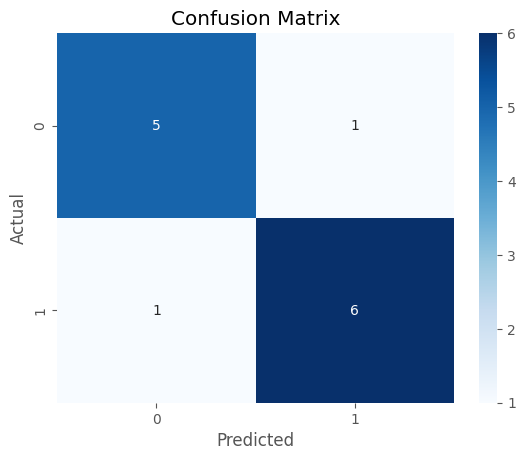

🧬 ROC AUC: 0.8571


In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities and convert to binary labels
y_probs = model.predict(X_val).flatten()
y_pred = (y_probs > 0.5).astype(int)

# Classification report
print("📄 Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_val, y_probs)
print(f"🧬 ROC AUC: {roc_auc:.4f}")


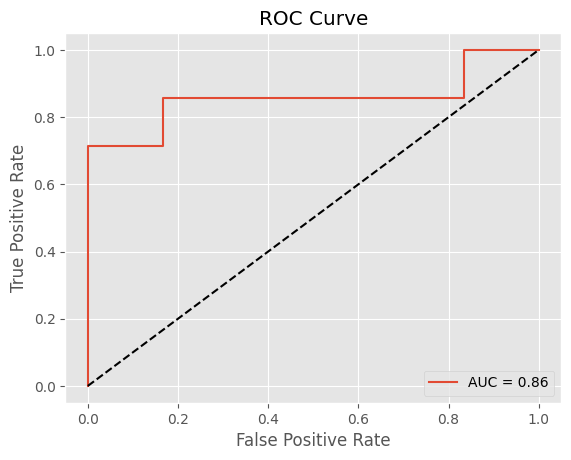

In [41]:
fpr, tpr, _ = roc_curve(y_val, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
